# ssvep_select_unicorn-clean_data

This python notebook is used to clean up and reformat the data generated from Unicorn Recorder when running the experiment from [ssvep_select_unicorn.py](ssvep_select_unicorn.py).

The code looks first add column headers to columns for EEG data and stimulation markers as `EEG_Ch1(mV)`,	`EEG_Ch2(mV)`,	`EEG_Ch3(mV)`,	`EEG_Ch4(mV)`,	`EEG_Ch5(mV)`,	`EEG_Ch6(mV)`,	`EEG_Ch7(mV)`,	`EEG_Ch8(mV)` and `stim` respectively. 

It then for the small gaps in the `stim` column due to the lag in keyboard input, and creates a new column at the end called `filled_stim`.

It is necessary to specify the file path of the original data file, and the output will will be saved under the same directory with the same file name, but with a suffix of `_cleaned`.

When decoding, please use the raw EEG channels as input data, and use `filled_stim` as labels.

In [42]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

file_path = r"~\Downloads\NoOscar_UnicornRecorder_11_06_2024_22_51_270_Lily_modified.csv"
df = pd.read_csv(file_path,header=None)

num_columns = df.shape[1]
col_headers = ["" for _ in range(num_columns)]

for i in range(num_columns):
    if  i < 8: col_headers[i] = f"EEG_Ch{i+1}(mV)"
    if i == num_columns-1: col_headers[i] = "stim"

df.columns = col_headers

print(df.head())

   EEG_Ch1(mV)  EEG_Ch2(mV)  EEG_Ch3(mV)  EEG_Ch4(mV)  EEG_Ch5(mV)  \
0     61526.19     61526.19     61526.19     61526.19     61526.19   
1    244614.70    244614.70    244614.70    244614.70    242912.50   
2    466291.40    464026.10    471058.20    471058.20    456283.20   
3    617714.20    611278.90    643291.60    643291.60    593542.40   
4    659654.30    653190.50    729156.80    729156.80    625096.90   

   EEG_Ch6(mV)  EEG_Ch7(mV)  EEG_Ch8(mV)          stim  
0     60735.64     61526.19     61526.19   0.000     0  
1    229174.00    244614.70    234560.10  13.170     0  
2    409508.10    471058.20    424157.80   2.547     0  
3    512156.40    643291.60    535502.10   2.459     0  
4    526406.30    729156.80    553177.10  12.713     0  


Mean gap length: 11.366221706326176
Standard deviation of gap lengths: 85.10986926078813
Threshold for significant gaps: 19.877208632404987
Significant gaps found: 17
      Length     Index_Range
0        142        (0, 141)
1         36      (143, 178)
127      988    (1008, 1995)
128       49    (1997, 2045)
294      919    (3142, 4060)
295       51    (4062, 4112)
462     1261    (5188, 6448)
463       35    (6450, 6484)
646     1685    (7659, 9343)
647       42    (9345, 9386)
894     1490  (11008, 12497)
895       50  (12499, 12548)
1251     965  (14841, 15805)
1252      46  (15807, 15852)
1468    1395  (17253, 18647)
1469      49  (18649, 18697)
1722    1117  (20342, 21458)


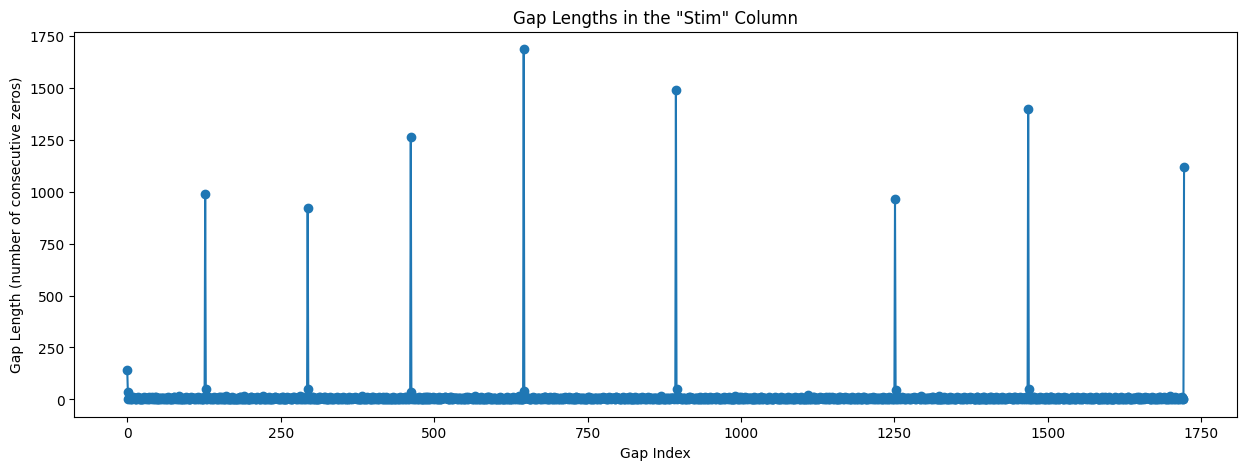

In [43]:
# Identify all the gaps of '0's
gaps = df['stim'] == 0
gap_lengths = []
gap_indices = []  # To store the start and end indices of each gap
current_gap_length = 0
start_index = None  # To track the start of a gap

# Calculate the length of each gap and their start and end indices
for i, is_gap in enumerate(gaps):
    if is_gap:
        current_gap_length += 1
        if current_gap_length == 1:
            start_index = i  # Mark the start of a new gap
    elif current_gap_length != 0:
        gap_lengths.append(current_gap_length)
        gap_indices.append((start_index, i - 1))  # Store start and end index of the gap
        current_gap_length = 0

# Add the last gap if it ends at the end of the dataset
if current_gap_length != 0:
    gap_lengths.append(current_gap_length)
    gap_indices.append((start_index, len(gaps) - 1))  # End index is the last index of the DataFrame

# Convert gap_lengths to a DataFrame for analysis
gap_lengths_df = pd.DataFrame({
    'Length': gap_lengths,
    'Index_Range': gap_indices
})

# Calculate statistics to find significant gaps
mean_length = gap_lengths_df['Length'].mean()
std_dev = gap_lengths_df['Length'].std()

# Define a threshold for significant gaps
threshold = mean_length + 0.1 * std_dev # The threshold is rather strict to ensure that 

# Identify significant gaps
significant_gaps = gap_lengths_df[gap_lengths_df['Length'] > threshold]

print("Mean gap length:", mean_length)
print("Standard deviation of gap lengths:", std_dev)
print("Threshold for significant gaps:", threshold)
print("Significant gaps found:", len(significant_gaps))
print(significant_gaps)

# Plot the gap lengths
plt.figure(figsize=(15, 5))
plt.plot(gap_lengths, marker='o', linestyle='-')
plt.title('Gap Lengths in the "Stim" Column')
plt.xlabel('Gap Index')
plt.ylabel('Gap Length (number of consecutive zeros)')
plt.show()

In [44]:
# fill all gaps
df['filled_stim'] = df['stim'].copy()
df['filled_stim'] = df['filled_stim'].replace(0, pd.NA)
pd.set_option('future.no_silent_downcasting', True)
df['filled_stim'] = df['filled_stim'].ffill().bfill()
df['filled_stim'] = df['filled_stim'].fillna(0)

# ensure significant gaps remain zero
for _, row in significant_gaps.iterrows():
    start_index = row["Index_Range"][0]
    end_index = row["Index_Range"][1]
    df.loc[start_index:end_index, 'filled_stim'] = 0

print(df.head())

file_path_parts = file_path.rsplit('.', 1)
new_file_path = file_path_parts[0] + '_cleaned.' + file_path_parts[1]
df.to_csv(new_file_path) 

print(f"Reformatted data saved to {new_file_path}")

   EEG_Ch1(mV)  EEG_Ch2(mV)  EEG_Ch3(mV)  EEG_Ch4(mV)  EEG_Ch5(mV)  \
0     61526.19     61526.19     61526.19     61526.19     61526.19   
1    244614.70    244614.70    244614.70    244614.70    242912.50   
2    466291.40    464026.10    471058.20    471058.20    456283.20   
3    617714.20    611278.90    643291.60    643291.60    593542.40   
4    659654.30    653190.50    729156.80    729156.80    625096.90   

   EEG_Ch6(mV)  EEG_Ch7(mV)  EEG_Ch8(mV)          stim filled_stim  
0     60735.64     61526.19     61526.19   0.000     0           0  
1    229174.00    244614.70    234560.10  13.170     0           0  
2    409508.10    471058.20    424157.80   2.547     0           0  
3    512156.40    643291.60    535502.10   2.459     0           0  
4    526406.30    729156.80    553177.10  12.713     0           0  
Reformatted data saved to ~\Downloads\NoOscar_UnicornRecorder_11_06_2024_22_51_270_Lily_modified_cleaned.csv
